(week4:clip_bands)=
# Clipping multiple bands-- v0.3

2025/Mar/15: Now writes out the fmask file using rasterio (rioxarray doesn't seem to be able to handle 8 bit data)
see 

2025/Feb/27: Fixed a problem where the datatype of the clipped arrays was changed from float32 to int16 when creating geotiffs.  See {ref}`clip:create_arrays` for the new code.

## Introduction

We are going to need to look at bands 2, 3, 4, 5, 9, 10 and 11.  This notebook uses the clipped band we wrote in
{ref}`week3:image_zoom` to get the clipping box, then reads in each of these bands, clips to the same box
and writes them out to new smaller geotifs.

- Download clip_bands.ipynb from the [week4 folder](https://drive.google.com/drive/folders/1-Ja2wVKVIjkZb7Gx_rfc14J_aBYiknuw?usp=sharing)
- You'll also need to copy the 5 NASA hls tif files in the [vancouver](https://drive.google.com/drive/folders/1UwTc4MnneI2eZ6rHqKFzF4YdRRbQi4sS?usp=sharing) folder into a new folder on your drive called `~/repos/a301/satdata/landsat/vancouver`

In [1]:
import copy
import pprint
from pathlib import Path
from osgeo import gdal
import json
import os
import cartopy
import numpy as np
import numpy.random
import rasterio
from affine import Affine
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from pyproj import CRS, Transformer
import rioxarray
import xarray as xr
from cartopy import crs as ccrs
from a301_lib import make_pal
import datetime

## Get the original hls tif files from disk

This cell finds all the 3660 x 3660 landsat tifs we downloaded in the satdata/landsat/vancouver folder.  We can use the `*` wildcard
so we don't have to type in long filenames, and the `**` wildcard so we look in all subfolders.  If you're interested  here's
the [wikipedia entry on globbing](https://en.wikipedia.org/wiki/Glob_(programming)#:~:text=6%20References-,Origin,command%3A%20%2Fetc%2Fglob.)

In [2]:
data_dir = Path().home() / 'repos/a301/satdata/landsat'
#the_tifs = list(data_dir.glob('**/vancouver_2023/HLS.L30*tif'))
the_tifs = list(data_dir.glob('**/vancouver_2023/HLS.L30*tif'))
print(the_tifs)

[PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.Fmask.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B05.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B11.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B10.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B04.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B06.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B07.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B03.tif'), PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B02.tif')

## Examine the geotif metadata

### Using gdalinfo from the terminal

It turns out that rioxarray only copies part of the metadata into the `DataArray`.  To get all the metadata, we can use the underlying [gdal module](https://gdal.org/en/stable/programs/gdalinfo.html). Do the following:

- open a terminal
- cd to the folder holding the geotiff
- type `gdalinfo your_tif_name_here.tif`

For a shorter summary, you can use the `rasterio` command line tool `rio`:

- `rio info you_tif_name_here.tif`

### Using the python gdal api

We can also do that from inside python.  To get all the information for the first tif, do:

In [3]:
info = gdal.Info(the_tifs[1], format='json')
info.keys()

/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


dict_keys(['description', 'driverShortName', 'driverLongName', 'files', 'size', 'coordinateSystem', 'geoTransform', 'metadata', 'cornerCoordinates', 'wgs84Extent', 'bands', 'stac'])

### Dump all the metadata

You can print the  `info` dictionary to see the full gdal metadata dictionary.
Scanning through it, will see that the `metadata` key has two sub-keys:

In [4]:
print(f"{info['metadata'].keys()=}")

info['metadata'].keys()=dict_keys(['', 'IMAGE_STRUCTURE'])


And looking at the first key shows all of the metadata that rioxarray transfers to the DataArray attributes.  these are the entries that we'll need to change for our clipped, scaled image.  We need to change `NCOLS, NROWS, ULX, ULY and scale_factor` when we write the clipped geotif.  Descriptions of each of the metadata items are in the [hls user guide](https://lpdaac.usgs.gov/documents/1007/HLS_User_Guide_V15_provisional.pdf)

In [5]:
print(f"{info['metadata'][''].keys()=}")

info['metadata'][''].keys()=dict_keys(['ACCODE', 'add_offset', 'arop_ave_xshift(meters)', 'arop_ave_yshift(meters)', 'arop_ncp', 'arop_rmse(meters)', 'arop_s2_refimg', 'cloud_coverage', 'HLS_PROCESSING_TIME', 'HORIZONTAL_CS_NAME', 'L1_PROCESSING_TIME', 'LANDSAT_PRODUCT_ID', 'LANDSAT_SCENE_ID', 'long_name', 'MEAN_SUN_AZIMUTH_ANGLE', 'MEAN_SUN_ZENITH_ANGLE', 'MEAN_VIEW_AZIMUTH_ANGLE', 'MEAN_VIEW_ZENITH_ANGLE', 'NBAR_SOLAR_ZENITH', 'NCOLS', 'NROWS', 'OVR_RESAMPLING_ALG', 'PROCESSING_LEVEL', 'scale_factor', 'SENSING_TIME', 'SENSOR', 'SENTINEL2_TILEID', 'spatial_coverage', 'SPATIAL_RESOLUTION', 'TIRS_SSM_MODEL', 'TIRS_SSM_POSITION_STATUS', 'ULX', 'ULY', 'USGS_SOFTWARE', '_FillValue', 'AREA_OR_POINT'])


We want to check the `long_name` key in particular, to make sure we are looking at the right wavelength:

In [6]:
print(f"{info['metadata']['']['long_name']=}")

info['metadata']['']['long_name']='NIR'


The exact wavelength range for each hls landsat band is given in the [spectral band table](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-spectral-bands)

## Read the bands into a dictionary

We're ready to read all of the bands into a dictionary, keyed by the band `long_name`.  All the band names are listed in the
[spectral band table](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-spectral-bands). Note one complication -- the `unit` attribute is only present for brightness temperatures, not reflectivities.

Note on the next cell:

- Because we set `masked_and_scale=True`, all `-9999` values are changed to `np.nan` and the data is multiplied by the scale factor and converted from `int16` to `float32`

In [7]:
band_dict={}
for tif_path in the_tifs:
    #
    # skip fmask for now
    #
    if 'Fmask' in str(tif_path):
        hls_band = rioxarray.open_rasterio(tif_path)
        band_name = 'fmask'
        hls_band = hls_band.assign_attrs(long_name='fmask')
        print(f"assigning longname to {band_name}")
    else:
        hls_band = rioxarray.open_rasterio(tif_path,mask_and_scale=True)
        band_name = hls_band.long_name
    print(f"{band_name=},{tif_path=}")
    band_dict[band_name] = hls_band
    if 'unit' in hls_band.attrs:
        print(f"{hls_band.unit=}")

assigning longname to fmask
band_name='fmask',tif_path=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.Fmask.tif')
band_name='NIR',tif_path=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B05.tif')
band_name='TIRS2',tif_path=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B11.tif')
hls_band.unit='Celsius'
band_name='TIRS1',tif_path=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B10.tif')
hls_band.unit='Celsius'
band_name='Red',tif_path=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B04.tif')
band_name='SWIR1',tif_path=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10UDV.2023178T190646.v2.0.B06.tif')
band_name='SWIR2',tif_path=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver_2023/HLS.L30.T10U

### check the dtype of the data and missing data

In [8]:
band_dict['Green'].dtype, band_dict['Green'].rio.nodata

(dtype('float32'), np.float32(nan))

## Read the clipped week3 band 5 bounding box

Next we want to get the affine transform from week 3 clipped band file, so we can set the same bounding box for all tifs

(bounding_box)=
### Create the bounding box using the upper left and lower right corners

This should be identical to the bounding box we found in {ref}`zoom_landsat_array`, which was:

`bounding_box=(476100.0, 5447460.0, 488100.0, 5465460.0)`

We can get them using the clipped affine transform.  Again, we search for the file using wild cards.  We just want
the first file we find, which means we need convert the python generator returned by glob into a list we can index.

In [9]:
filename =  list(data_dir.glob('**/band5_clipped*'))[0]
print(filename)
clipped_5 = rioxarray.open_rasterio(filename,masked=True)
clipped_transform = clipped_5.rio.transform()
clipped_transform

/Users/phil/repos/a301/satdata/landsat/band5_clipped_rio.tif


Affine(30.0, 0.0, 476100.0,
       0.0, -30.0, 5465460.0)

In [10]:
band, nrows, ncols = clipped_5.shape
nrows, ncols

(600, 400)

In [11]:
ul_x, ul_y = clipped_transform * (0, 0)
lr_x, lr_y = clipped_transform * (ncols, nrows)
bounding_box = (ul_x, lr_y, lr_x, ul_y)
print(f"{bounding_box=}")

bounding_box=(476100.0, 5447460.0, 488100.0, 5465460.0)


### Get the pyproj crs to copy to output tif

We want the improved crs we wrote out in {ref}`week3:image_zoom` for the band5 clipped tif, since  it includes the epsg code

In [12]:
good_crs = clipped_5.rio.crs
print(f"{good_crs.to_epsg()=}")

good_crs.to_epsg()=32610


(clip:create_arrays)=
## Create new clipped arrays

Fixed in version 0.2:  Just copying all the metadata from the original NASA files led to issues with missing data values and the ouput datatype for the data. To fix this, create the rioxarray DataArrays from scratch with
only those attributes that are consistent with the new mask_and_scaled array.
We'll add more attributes in {ref}`change_attrs` below. In particular note
that ULX, ULY, NROWS and NCOLS have not been updated from the original full scene.

In [13]:
def make_new_array(rio_da,crs=None):
    """
    transfer data into from rio_da into a fresh DataArray, copying only the selected metadata
    from rio_da.  This avoids copying old metadata from the original hls tif file

    Parameters
    ----------

    rio_da: xarray DataArray
       a DataArray with rasterio metadata
    crs: optional pyproj crs
       a crs which is able to return its epsg code
       if it's missing, the crs from rio_da will be copied

    Returns
    -------

    clipped_da: xarray.DataArray
      a DataArray with metadata and data copied from rio_da
    

    
    """
    #
    # NASA hls files have bad crs, so allow for an override parameter
    #
    print("inside")
    if crs is None:
        crs = rio_da.rio.crs
    clipped_da=xr.DataArray(rio_da.data,coords=rio_da.coords,
                            dims=rio_da.dims)
    clipped_da.rio.write_crs(crs, inplace=True)
    clipped_da.rio.write_transform(rio_da.rio.transform(), inplace=True)
    #print(rio_da.attrs)
    if 'long_name' in rio_da.attrs:
        clipped_da=clipped_da.assign_attrs(rio_da.attrs)
        clipped_da = clipped_da.rio.set_nodata(np.float32(np.nan))
    else:
        attrs = {'long_name' : rio_da.attrs['long_name']}
        print(clipped_da.dtype)
        #clipped_da = clipped_da.rio.set_nodata(None)
        print(f"{clipped_da.rio.long_name}, {type(clipped_da.rio.nodata)}")
    return clipped_da

In [14]:
band_clipped = {}
for key, value in band_dict.items():
    print(value.long_name)
    the_array = value.rio.clip_box(*bounding_box)
    new_clipped = make_new_array(the_array,crs = good_crs)
    band_clipped[key]=new_clipped

fmask
inside
NIR
inside
TIRS2
inside
TIRS1
inside
Red
inside
SWIR1
inside
SWIR2
inside
Green
inside
Blue
inside
Coastal_Aerosol
inside
Cirrus
inside


In [15]:
var='fmask'
fmask = band_clipped[var]
#fmask.rio.to_raster("test_fmask.tif")

## Check the brightness temperature in band 11

In [16]:
print(band_clipped[key].rio.nodata)

nan


Text(0.5, 1.0, 'band TIRS2 (Celsius)')

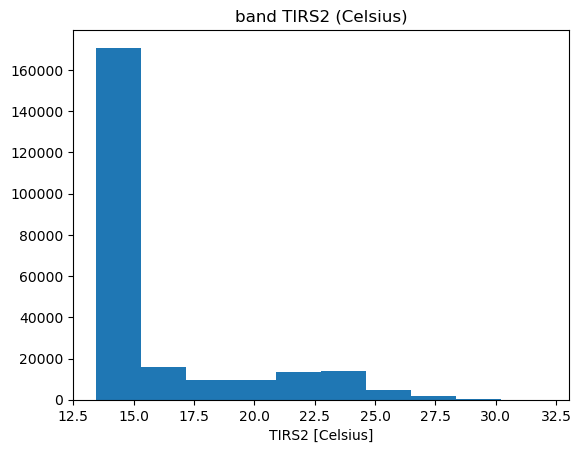

In [17]:
key = 'TIRS2'
fig, ax = plt.subplots(1,1)
band_clipped[key].plot.hist(ax = ax)
ax.set_title(f"band {key} ({band_dict[key].unit})")

## Write the clipped geotiffs

Put these into the vancouver folder.  We can copy code from {ref}`week3:write_clipped`

(change_attrs)=
### change some attributes

We need to adjust some of the attributions for the new subscene.  To do this, copy the exiting attributes into
a dictionary and rewrite the parts you want to change, adding any extras.

In [18]:
band_clipped['Red'].dtype,band_clipped['Red'].rio.nodata

(dtype('float32'), np.float32(nan))

In [19]:
value.rio.set_nodata(np.float32(np.nan),inplace=True)
type(value.rio._nodata)

numpy.float32

In [20]:
for key, value in band_clipped.items():
    new_attrs = copy.deepcopy(value.attrs)
    new_attrs['ULX']= ul_x
    new_attrs['ULY'] = ul_y
    band, nrows, ncols = value.shape
    new_attrs['NROWS'] = nrows
    new_attrs['NCOLS'] = ncols
    # new_attrs['FillValue'] = np.nan
    new_attrs['history'] = "v0.3 -- written by the week4 clip_bands notebook"
    value.rio.update_attrs(new_attrs, inplace = True)
    #
    # update_attrs seems to destroy the rio.nodata attribute
    #
    value.rio.set_nodata(np.float32(np.nan),inplace=True);

#### check the attributes

In [21]:
value.attrs['history'],value.dtype,value.rio.nodata

('v0.3 -- written by the week4 clip_bands notebook',
 dtype('float32'),
 np.float32(nan))

### Write out the new geotiffs

In [22]:
band_clipped['fmask'][0,-1,-10:]

<xarray.DataArray (x: 10)> Size: 10B
array([128, 128, 128, 128, 128, 192, 192, 192, 192, 192], dtype=uint8)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 80B 4.878e+05 4.878e+05 ... 4.881e+05 4.881e+05
    y            float64 8B 5.447e+06
    spatial_ref  int64 8B 0
Attributes: (12/38)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 fmask
    _FillValue:                255
    history:                   v0.3 -- written by the week4 clip_bands notebook

### New function: write_fmask

need to call rasterio directly since rioxarray can't handle 8 bit data

In [23]:
def write_fmask(
      filename: str | os.PathLike,
       da_value: xr.DataArray) -> None:
    """
    use rasterio to write out the clipped fmask

    Parameter:
    
    """
    
    data = da_value.data.squeeze()
    dtype = data.dtype
    crs = da_value.rio.crs
    transform = fmask.rio.transform()
    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,  # Number of bands
        dtype=dtype,  # Data type (8-byte float)
        crs=crs,  # Coordinate Reference System (WGS84)
        transform=transform
    ) as dst:
        dst.write(data, 1)  # Write the array to the first band
        dst.update_tags(
            history="written by a301_extras/write_fmask",
            written_on=str(datetime.date.today()),
        )
        dst.update_tags(1,long_name="fmask")

In [24]:
for key, value in band_clipped.items():
    band_name = value.long_name
    print(f"{band_name=}")
    tif_filename = data_dir / 'vancouver' / f"week10_clipped_{band_name}.tif"
    #
    # remove the file if it already exists
    #
    if tif_filename.exists():
        tif_filename.unlink()
    if value.long_name == 'fmask':
        write_fmask(tif_filename,value)
    else:
        value.rio.to_raster(tif_filename)

band_name='fmask'
band_name='NIR'
band_name='TIRS2'
band_name='TIRS1'
band_name='Red'
band_name='SWIR1'
band_name='SWIR2'
band_name='Green'
band_name='Blue'
band_name='Coastal_Aerosol'
band_name='Cirrus'


### read one back in to check

In [25]:
filename = tif_filename = data_dir / 'vancouver' / f"week10_clipped_fmask.tif"
fmask =  rioxarray.open_rasterio(filename,masked=False)
fmask

<xarray.DataArray (band: 1, y: 600, x: 400)> Size: 240kB
[240000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB 4.761e+05 4.761e+05 ... 4.881e+05 4.881e+05
  * y            (y) float64 5kB 5.465e+06 5.465e+06 ... 5.448e+06 5.447e+06
    spatial_ref  int64 8B 0
Attributes:
    history:        written by a301_extras/write_fmask
    written_on:     2025-03-16
    AREA_OR_POINT:  Area
    long_name:      fmask
    scale_factor:   1.0
    add_offset:     0.0

tif_filename=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver/week10_clipped_NIR.tif')
small_band.data[0,-1,-10:]=array([0.2267    , 0.2403    , 0.2048    , 0.2057    , 0.2149    ,
       0.18509999, 0.21      , 0.2444    , 0.2392    , 0.24409999],
      dtype=float32)
(band_name, small_band.dtype)=('NIR', dtype('float32'))


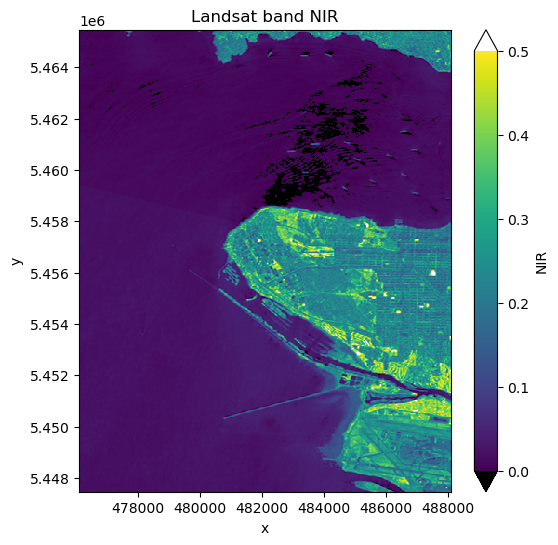

In [26]:
tif_filename = list(data_dir.glob("**/*week10*NIR.tif"))[0]
print(f"{tif_filename=}")
has_file = tif_filename.exists()
if not has_file:
    raise IOError(f"can't find {filename}, something went wrong above") 
small_band = rioxarray.open_rasterio(tif_filename,mask_and_scale=True)
print(f"{small_band.data[0,-1,-10:]=}")
small_band = small_band.squeeze()
band_name = small_band.long_name
print(f"{(band_name, small_band.dtype)=}")
fig, ax = plt.subplots(1,1, figsize=(6,6))
vmin, vmax = 0.,0.5
pal_dict = make_pal(vmin=vmin,vmax=vmax)
small_band.plot.imshow(ax=ax,
                    norm = pal_dict['norm'],
                    cmap = pal_dict['cmap'],
                    extend = "both")
ax.set_title(f"Landsat band {band_name}");

In [27]:
small_band.attrs['history']

'v0.3 -- written by the week4 clip_bands notebook'

#### note that we now have the correct epsg code

Because we used the pyproj `good_crs` in our raster write we've fixed the missing epsg code problem.

In [28]:
small_band.rio.crs.to_epsg(), small_band.rio.nodata,small_band.dtype

(32610, np.float32(nan), dtype('float32'))

#### Check the metadata

Write all the metadata out to a file for a detailed check

In [29]:
info = gdal.Info(tif_filename, format='json')
print(f"{tif_filename=}")
with open('dump.json','w') as fp:
    json.dump(info,fp,indent=4)

tif_filename=PosixPath('/Users/phil/repos/a301/satdata/landsat/vancouver/week10_clipped_NIR.tif')
